# AutoML library to get good regressor for the dataset

   ## Library can handle following:
       1. Deal with missing values in data-set
       2. Scaling for numerical values
       3. Encoding for categorical values
       4. Feature selection through F-test (ANOVA)
   ## The library can give a tuned model by evaluating following regressors:
       1. Linear Regression
       2. Random Forest Regression
       3. XG Boost Regression
       4. Elastic Net Regression
   ## Cross-validation is used to prevent over-fitting on training set
   ## Scoring function to select model is Root Mean Square Error

In [48]:
## Importing necessary libraries

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [49]:
## Class containing code to find the best model

class AutoML_Regressor:

    def fit(self, X, y):
        X_train = X
        y_train = y

        categories = []
        
        categorical_columns = X_train.select_dtypes(include = ['category','bool', 'object'])

        for i in range(categorical_columns.shape[1]):
            categories.append(list(categorical_columns.iloc[:,i].dropna().unique()))

        preprocessor = ColumnTransformer([
          ('numerical', Pipeline([('cleaner', SimpleImputer()), ('scaler', StandardScaler())]), make_column_selector(dtype_exclude=['object','category','bool'])),
          ('categorical', Pipeline([('cleaner', SimpleImputer(strategy = 'most_frequent')), ('encoder', OneHotEncoder(sparse = False, categories=categories))]), make_column_selector(dtype_include=['object','category','bool']))
        ])

        model_pipeline_step = []
        model_pipeline_step.append(('preprocessor',preprocessor))
        model_pipeline_step.append(('feature_selector',SelectKBest(f_regression,k='all')))
        model_pipeline_step.append(('estimator',LinearRegression()))
        model_pipeline = Pipeline(model_pipeline_step)

        features = preprocessor.fit_transform(X_train).shape[1]

        optimization_grid = []

        # Linear regression
        optimization_grid.append({
            'preprocessor__numerical__scaler':[RobustScaler(),StandardScaler(),MinMaxScaler()],
            'preprocessor__numerical__cleaner__strategy':['mean','median'],
            'feature_selector__k': list(np.arange(1,features,5)),
            'estimator':[LinearRegression()]})

        # Random Forest Regressor
        optimization_grid.append({
        'preprocessor__numerical__scaler':[None],
        'preprocessor__numerical__cleaner__strategy':['mean','median'],
        'feature_selector__k': list(np.arange(1,features,5)),
        'estimator':[RandomForestRegressor(random_state=0)],
        'estimator__n_estimators':np.arange(5,1000,20),
        'estimator__criterion':['gini','entropy'],
        'estimator__max_depth': [2, 4, 6, 8, 10],
        'estimator__min_samples_split': [2, 5, 10, 15, 100],
        'estimator__min_samples_leaf': [1, 2, 5, 10]})

        # XG Boost
        optimization_grid.append({
            'preprocessor__numerical__scaler':[None],
            'preprocessor__numerical__cleaner__strategy':['mean','median'],
            'feature_selector__k': list(np.arange(1,features,5)),
            'estimator':[GradientBoostingRegressor(random_state=0)],
            'estimator__n_estimators':np.arange(5,1000,20),
            'estimator__learning_rate':np.linspace(0.1,0.9,20),
            'estimator__subsample': [0.9, 0.5, 0.2, 0.1],
            'estimator__max_depth': [2, 4, 6, 8, 10]})
        
        # Elastic Net Regression
        optimization_grid.append({
            'preprocessor__numerical__scaler':[RobustScaler(),StandardScaler(),MinMaxScaler()],
            'preprocessor__numerical__cleaner__strategy':['mean','median'],
            'feature_selector__k': list(np.arange(1,features,5)),
            'estimator':[ElasticNet(random_state = 0)],
            'estimator__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
            'estimator__l1_ratio': np.arange(0, 1, 0.01)})

        search = RandomizedSearchCV(model_pipeline, optimization_grid, n_iter=250, scoring = 'neg_root_mean_squared_error', n_jobs = -1, random_state = 0, verbose = 3, cv = 10)

        search.fit(X_train, y_train)
        self.best_estimator_ = search.best_estimator_
        self.best_pipeline = search.best_params_
        self.optimization_grid = optimization_grid
        self.model_pipeline = model_pipeline

    def predict(self,X,y = None):
        return self.best_estimator_.predict(X)

In [50]:
## Example for choosing best regressor for the Boston House prices dataset

In [51]:
from sklearn import datasets
boston = datasets.load_boston()

In [52]:
boston2 = pd.DataFrame(boston['data'], columns = boston['feature_names'])

In [53]:
boston2['PRICE'] = boston['target']
boston2.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


In [54]:
y = boston2['PRICE']

In [55]:
X = boston2.iloc[:, 0:len(boston2.columns) - 1]

In [56]:
# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
# Using the defined above to create a model
model = AutoML_Regressor()

In [58]:
# Fitting model on the training data-set
model.fit(X_train,y_train)

Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1616 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2128 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  2.8min finished


In [59]:
# Checking R2 score for best regressor
r2_score(y_test, model.predict(X_test))

0.8892444983177056

In [60]:
# This is the best regressor as determined by the AutoML_Regressor library
model.best_pipeline

{'preprocessor__numerical__scaler': None,
 'preprocessor__numerical__cleaner__strategy': 'median',
 'feature_selector__k': 11,
 'estimator__subsample': 0.5,
 'estimator__n_estimators': 405,
 'estimator__max_depth': 2,
 'estimator__learning_rate': 0.14210526315789473,
 'estimator': GradientBoostingRegressor(learning_rate=0.14210526315789473, max_depth=2,
                           n_estimators=405, random_state=0, subsample=0.5)}

In [61]:
# Getting model predictions for plotting
predictions = model.predict(X_test)

In [62]:
# Storing actual test datset results in np array for plotting
actual = np.array(y_test)

Text(0, 0.5, 'Actual')

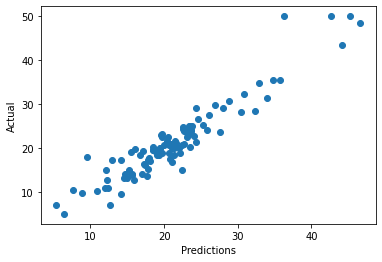

In [63]:
# Plotting actual vs predicted prices to see if the resulting trend is linear
plt.plot(predictions, actual, 'o')
plt.xlabel('Predictions')
plt.ylabel('Actual')